In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1
os.environ["CUDA_VISIBLE_DEVICES"]= '3'

import numpy as np
import matplotlib.pyplot as plt
import multielec_src.fitting as fitting
import multielec_src.multielec_utils as mutils
from scipy.io import loadmat
import multiprocessing as mp
import statsmodels.api as sm
from copy import deepcopy, copy
import visionloader as vl
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def sample_spikes(p_true, t):
    p_true, t = np.array(p_true), np.array(t).astype(int)
    
    p_empirical = []
    for i in range(len(p_true)):
        if t[i] == 0:
            p_empirical += [0.5]
        
        else:
            p_empirical += [np.mean(np.random.choice(np.array([0, 1]), 
                                                 p=np.array([1-p_true[i], p_true[i]]), 
                                                 size=t[i]))]
        
    p_empirical_array = np.array(p_empirical)

    return p_empirical_array

In [3]:
def sample_spikes_array(true_probs, trials, NUM_THREADS=24):

    input_list = []
    for i in range(len(true_probs)):
        for j in range(len(true_probs[i])):
            input_list += [(true_probs[i][j], trials[j])]
            
    pool = mp.Pool(processes=NUM_THREADS)
    results = pool.starmap_async(sample_spikes, input_list)
    mp_output = results.get()
    pool.close()

    return np.array(mp_output).reshape(true_probs.shape)
    

In [4]:
def get_performance_array(true_params, curr_probs, true_probs):
    
    error = 0
    cnt = 0
    for i in range(len(true_params)):
        for j in range(len(true_params[i])):
            if ~np.all(true_params[i][j][:, 0] == -np.inf):
                error += np.sqrt(np.sum((curr_probs[i][j] - true_probs[i][j])**2) / len(true_probs[i][j]))
                cnt += 1

    return error / cnt

In [5]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2020-10-06-7"
wnoise = "kilosort_data000/data000"
spont_limit = 0.2
min_active_inds = 200

estim_neg = "data003/data003-all"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))

for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        if np.count_nonzero(all_probs[i][j] >= spont_limit) >= min_active_inds:
            print(cells[i], j+1)

81 1
84 1
85 1
171 2
244 1
259 2
275 2
292 2
296 3
301 3
399 3


In [12]:
cell = 244
pattern = 1

trials = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
trials = trials[pattern-1][None, :]
amps = np.array([mutils.get_stim_amps_newlv(electrical_path, pattern)] * len(trials))

probs_np = all_probs[np.where(cells == cell)[0][0]][pattern-1][None, None, :]

clean_inds_array = np.full((probs_np.shape[0], probs_np.shape[1]), 
                            None, dtype=object)

clean_inds = mutils.triplet_cleaning(amps[0], probs_np[0][0], trials[0],
                                        return_inds=True)
clean_inds_array[0][0] = clean_inds

In [13]:
ms = [1, 2, 3, 4, 5, 6]

w_inits_array = np.zeros((probs_np.shape[0], probs_np.shape[1]), dtype=object)
for i in range(len(w_inits_array)):
    for j in range(len(w_inits_array[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array[i][j] = w_inits

In [14]:
input_list = fitting.generate_input_list(probs_np, amps, trials, w_inits_array, spont_limit,
                                         pass_inds=clean_inds_array)

pool = mp.Pool(processes=24)
results = pool.starmap_async(fitting.fit_surface, input_list)
mp_output = results.get()
pool.close()

In [15]:
params_true = np.zeros((probs_np.shape[0], probs_np.shape[1]), dtype=object)
inits = np.zeros((probs_np.shape[0], probs_np.shape[1]), dtype=object)
R2s = np.zeros((probs_np.shape[0], probs_np.shape[1]))

amps_scan = np.array([np.array(np.meshgrid(np.linspace(-2, 2, 21), 
                                np.linspace(-2, 2, 21),
                                np.linspace(-2, 2, 21))).T.reshape(-1,3)] * len(trials))
probs_true_scan = np.zeros((probs_np.shape[0], probs_np.shape[1], amps_scan.shape[1]))

cnt = 0
for i in range(len(probs_np)):
    for j in range(len(probs_np[i])):
        params_true[i][j] = mp_output[cnt][0]
        inits[i][j] = mp_output[cnt][1]
        R2s[i][j] = mp_output[cnt][2]
        
        probs_true_scan[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps_scan[j], has_constant='add'), 
                                params_true[i][j])
        

        cnt += 1

[[ -8.80760213  -1.14840697  -0.73630818  -7.85972803]
 [-12.5097023    0.70701138   0.8393285    8.92589957]
 [ -7.59483509  -4.33075163  -4.54060456  -1.17778131]
 [ -6.30051262   2.98746053   3.27338132   2.64262182]]
1270


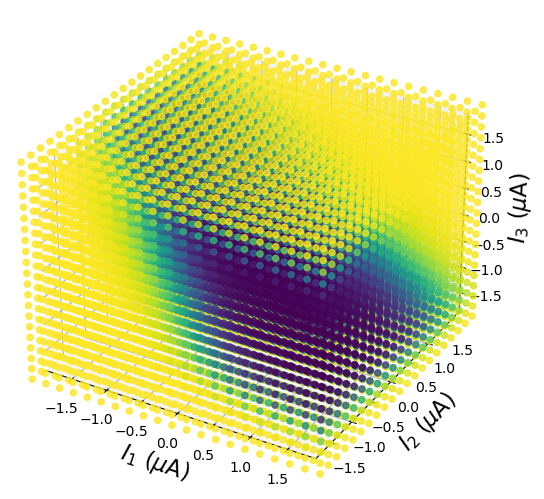

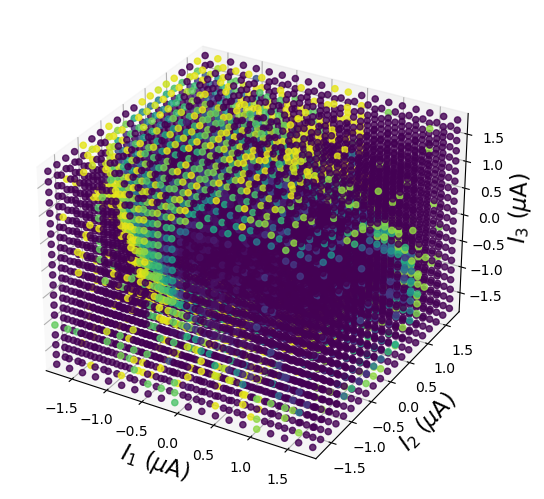

In [16]:
# CHECK DATASET IF NEEDED
from mpl_toolkits.mplot3d import Axes3D

for i in range(len(probs_np)):
    for j in range(len(probs_np[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            print(params_true[i][j])
            print(len(np.where(probs_np[i][j][clean_inds_array[i][j]] >= spont_limit)[0]))
            
            fig = plt.figure(0)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps_scan[j][:, 0], 
                              amps_scan[j][:, 1],
                              amps_scan[j][:, 2], marker='o', 
                              c=probs_true_scan[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            fig = plt.figure(1)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps[j][:, 0], 
                              amps[j][:, 1],
                              amps[j][:, 2], marker='o', 
                              c=probs_np[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(61030.047, dtype=float32), DeviceArray(2356.0378, dtype=float32), DeviceArray(68150.805, dtype=float32), DeviceArray(7120.757, dtype=float32))
1
(DeviceArray(55362.297, dtype=float32), DeviceArray(2426.976, dtype=float32), DeviceArray(63901.82, dtype=float32), DeviceArray(8539.521, dtype=float32))
2
(DeviceArray(51387.984, dtype=float32), DeviceArray(2407.1367, dtype=float32), DeviceArray(59530.72, dtype=float32), DeviceArray(8142.7344, dtype=float32))
3
(DeviceArray(48135.72, dtype=float32), DeviceArray(2406.2095, dtype=float32), DeviceArray(56259.906, dtype=float32), DeviceArray(8124.1895, dtype=float32))
4
(DeviceArray(45593.92, dtype=float32), DeviceArray(2476.3757, dtype=float32), DeviceArray(55121.438, dtype=float32), DeviceArray(9527.515, dtype=float32))
5
(DeviceArray(43745.758, dtype=float32), DeviceArray(2479.3726, dtype=float32), DeviceArray(53333.21, dtype=float32), DeviceArray

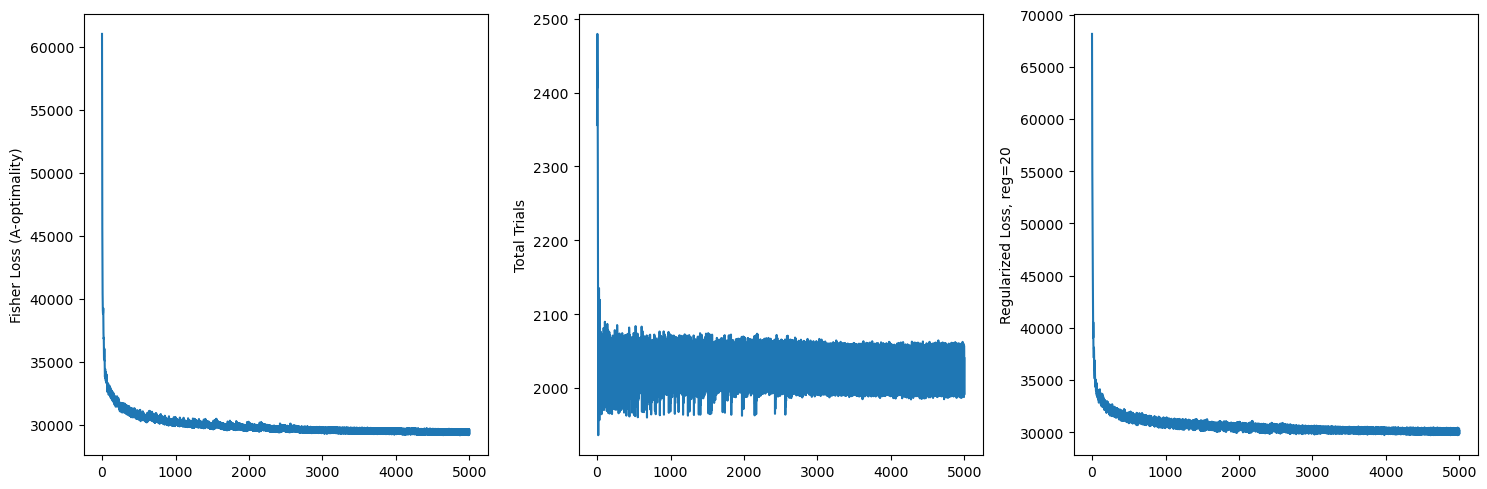

0.04932144800696928 0.04932144800696928


/tmp/ipykernel_42037/2274459269.py:110: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])


Setting up data...
Fitting dataset...


/tmp/ipykernel_42037/2274459269.py:123: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(21844.07, dtype=float32), DeviceArray(2281.4385, dtype=float32), DeviceArray(27472.84, dtype=float32), DeviceArray(5628.7695, dtype=float32))
1
(DeviceArray(22180.395, dtype=float32), DeviceArray(2167.6309, dtype=float32), DeviceArray(25533.012, dtype=float32), DeviceArray(3352.6172, dtype=float32))
2
(DeviceArray(22931.066, dtype=float32), DeviceArray(1924.7734, dtype=float32), DeviceArray(24435.598, dtype=float32), DeviceArray(1504.5312, dtype=float32))
3
(DeviceArray(22798.357, dtype=float32), DeviceArray(1936.5056, dtype=float32), DeviceArray(24068.246, dtype=float32), DeviceArray(1269.8877, dtype=float32))
4
(DeviceArray(22274.652, dtype=float32), DeviceArray(2075.6384, dtype=float32), DeviceArray(23787.422, dtype=float32), DeviceArray(1512.7686, dtype=float32))
5
(DeviceArray(22093.766, dtype=float32), DeviceArray(2101.7246, dtype=float32), DeviceArray(24128.258, dtype=float32), DeviceArray(2034.4922, dtype=float32))
6
(

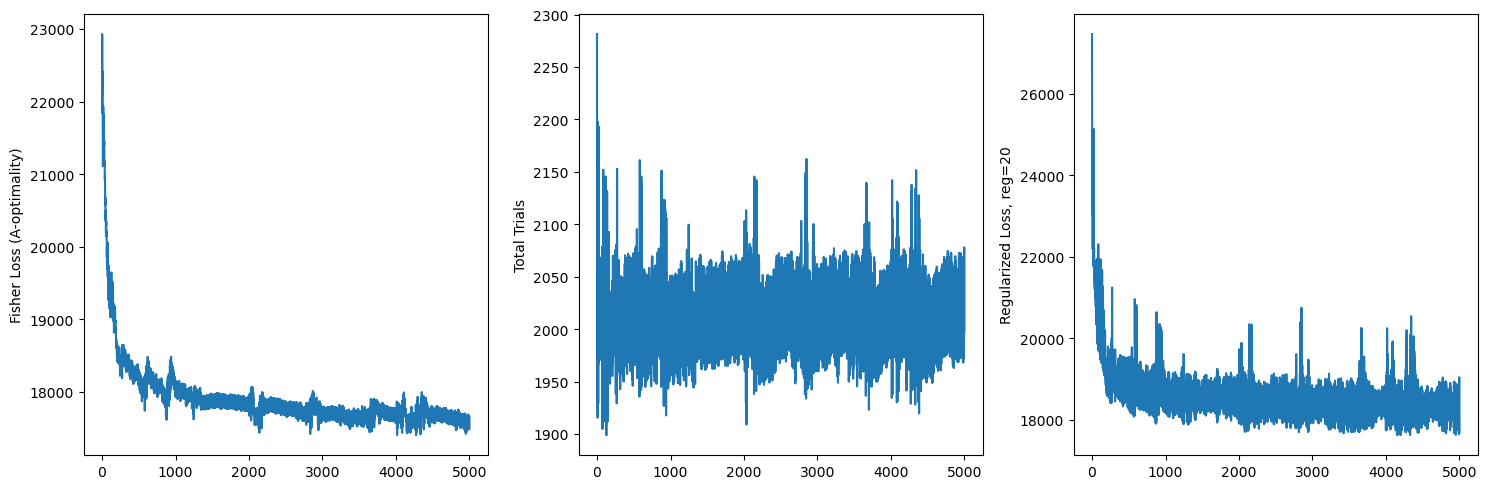

0.022822145256362676 0.03775999889609297


/tmp/ipykernel_42037/2274459269.py:110: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])


Setting up data...
Fitting dataset...


/tmp/ipykernel_42037/2274459269.py:123: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(13379.543, dtype=float32), DeviceArray(2283.2383, dtype=float32), DeviceArray(19044.309, dtype=float32), DeviceArray(5664.7656, dtype=float32))
1
(DeviceArray(13500.947, dtype=float32), DeviceArray(2172.999, dtype=float32), DeviceArray(16960.928, dtype=float32), DeviceArray(3459.9805, dtype=float32))
2
(DeviceArray(13777.402, dtype=float32), DeviceArray(1932.5262, dtype=float32), DeviceArray(15126.877, dtype=float32), DeviceArray(1349.4751, dtype=float32))
3
(DeviceArray(13787.709, dtype=float32), DeviceArray(1913.9663, dtype=float32), DeviceArray(15508.383, dtype=float32), DeviceArray(1720.6738, dtype=float32))
4
(DeviceArray(13649.205, dtype=float32), DeviceArray(2020.7795, dtype=float32), DeviceArray(14064.796, dtype=float32), DeviceArray(415.59082, dtype=float32))
5
(DeviceArray(13646.885, dtype=float32), DeviceArray(2010.999, dtype=float32), DeviceArray(13866.865, dtype=float32), DeviceArray(219.98047, dtype=float32))
6
(

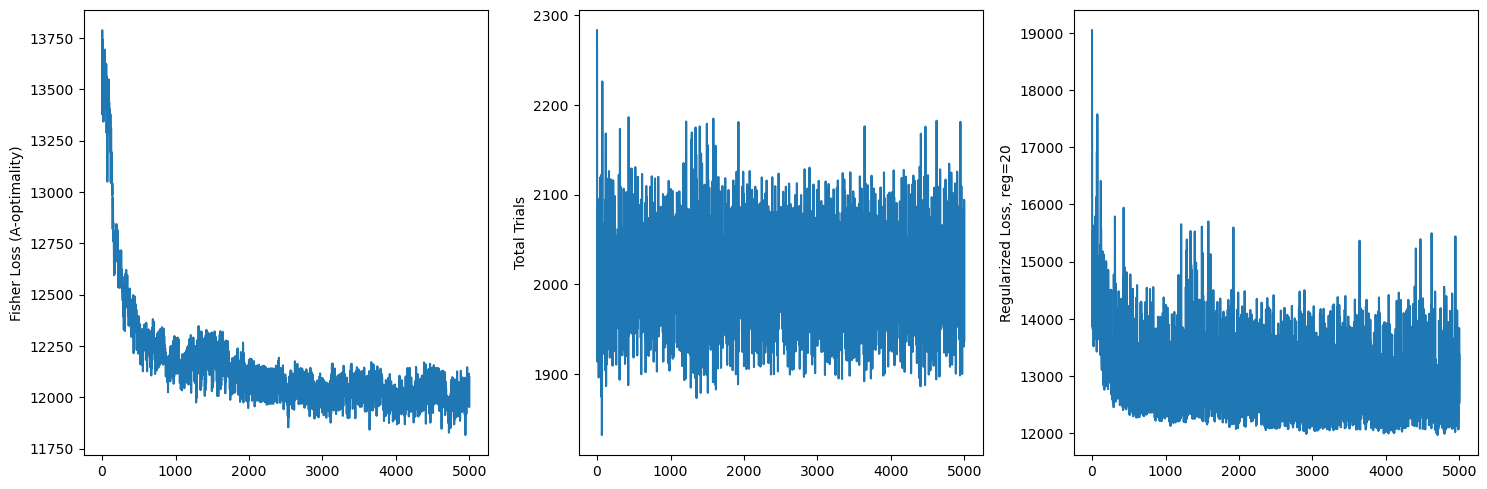

0.01759593610788626 0.024063628071814325


/tmp/ipykernel_42037/2274459269.py:110: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])


Setting up data...
Fitting dataset...


/tmp/ipykernel_42037/2274459269.py:123: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(9904.137, dtype=float32), DeviceArray(2283.6382, dtype=float32), DeviceArray(15576.9, dtype=float32), DeviceArray(5672.7637, dtype=float32))
1
(DeviceArray(9972.449, dtype=float32), DeviceArray(2173.9985, dtype=float32), DeviceArray(13452.42, dtype=float32), DeviceArray(3479.9707, dtype=float32))
2
(DeviceArray(10126.233, dtype=float32), DeviceArray(1933.9321, dtype=float32), DeviceArray(11447.591, dtype=float32), DeviceArray(1321.3574, dtype=float32))
3
(DeviceArray(10140.242, dtype=float32), DeviceArray(1907.7594, dtype=float32), DeviceArray(11985.055, dtype=float32), DeviceArray(1844.812, dtype=float32))
4
(DeviceArray(10072.945, dtype=float32), DeviceArray(2005.515, dtype=float32), DeviceArray(10183.246, dtype=float32), DeviceArray(110.30029, dtype=float32))
5
(DeviceArray(10081.607, dtype=float32), DeviceArray(1986.2277, dtype=float32), DeviceArray(10357.055, dtype=float32), DeviceArray(275.44678, dtype=float32))
6
(Devic

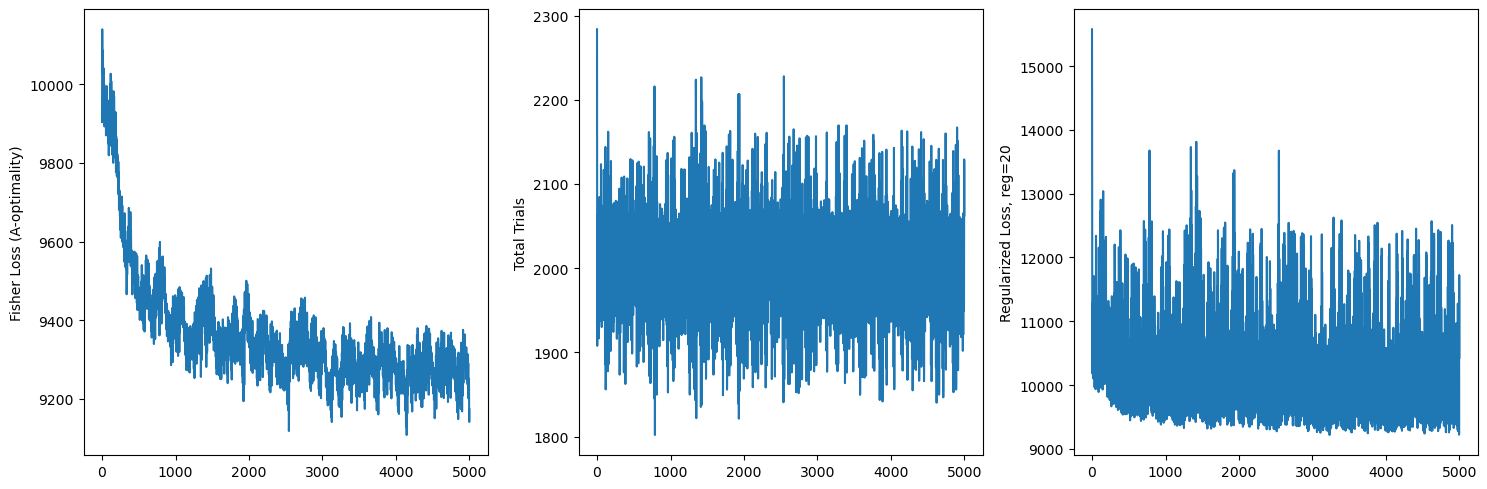

0.014823781862192544 0.02015392855545561


/tmp/ipykernel_42037/2274459269.py:110: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])


Setting up data...
Fitting dataset...


/tmp/ipykernel_42037/2274459269.py:123: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(8046.265, dtype=float32), DeviceArray(2283.9385, dtype=float32), DeviceArray(13725.035, dtype=float32), DeviceArray(5678.7695, dtype=float32))
1
(DeviceArray(8091.4287, dtype=float32), DeviceArray(2174.564, dtype=float32), DeviceArray(11582.708, dtype=float32), DeviceArray(3491.2793, dtype=float32))
2
(DeviceArray(8193.328, dtype=float32), DeviceArray(1934.6711, dtype=float32), DeviceArray(9499.905, dtype=float32), DeviceArray(1306.5771, dtype=float32))
3
(DeviceArray(8204.574, dtype=float32), DeviceArray(1905.3989, dtype=float32), DeviceArray(10096.596, dtype=float32), DeviceArray(1892.0215, dtype=float32))
4
(DeviceArray(8162.339, dtype=float32), DeviceArray(1999.3511, dtype=float32), DeviceArray(8175.3174, dtype=float32), DeviceArray(12.978516, dtype=float32))
5
(DeviceArray(8086.808, dtype=float32), DeviceArray(2173.798, dtype=float32), DeviceArray(11562.77, dtype=float32), DeviceArray(3475.962, dtype=float32))
6
(DeviceAr

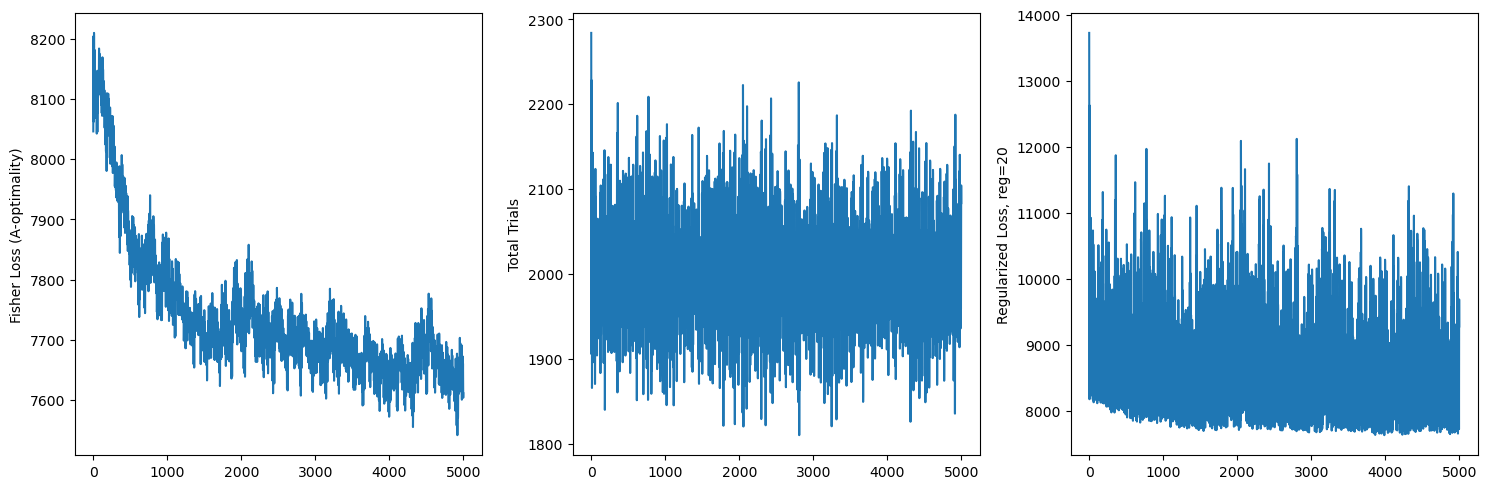

0.012842243106134838 0.017500837496555437


/tmp/ipykernel_42037/2274459269.py:110: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])


Setting up data...
Fitting dataset...


/tmp/ipykernel_42037/2274459269.py:123: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(6688.9453, dtype=float32), DeviceArray(2282.2383, dtype=float32), DeviceArray(12333.711, dtype=float32), DeviceArray(5644.7656, dtype=float32))
1
(DeviceArray(6720.1973, dtype=float32), DeviceArray(2172.129, dtype=float32), DeviceArray(10162.775, dtype=float32), DeviceArray(3442.5781, dtype=float32))
2
(DeviceArray(6790.102, dtype=float32), DeviceArray(1931.7772, dtype=float32), DeviceArray(8154.5576, dtype=float32), DeviceArray(1364.4556, dtype=float32))
3
(DeviceArray(6798.7085, dtype=float32), DeviceArray(1900.1941, dtype=float32), DeviceArray(8794.826, dtype=float32), DeviceArray(1996.1182, dtype=float32))
4
(DeviceArray(6770.95, dtype=float32), DeviceArray(1991.4641, dtype=float32), DeviceArray(6941.668, dtype=float32), DeviceArray(170.71777, dtype=float32))
5
(DeviceArray(6720.266, dtype=float32), DeviceArray(2163.2747, dtype=float32), DeviceArray(9985.76, dtype=float32), DeviceArray(3265.4932, dtype=float32))
6
(DeviceA

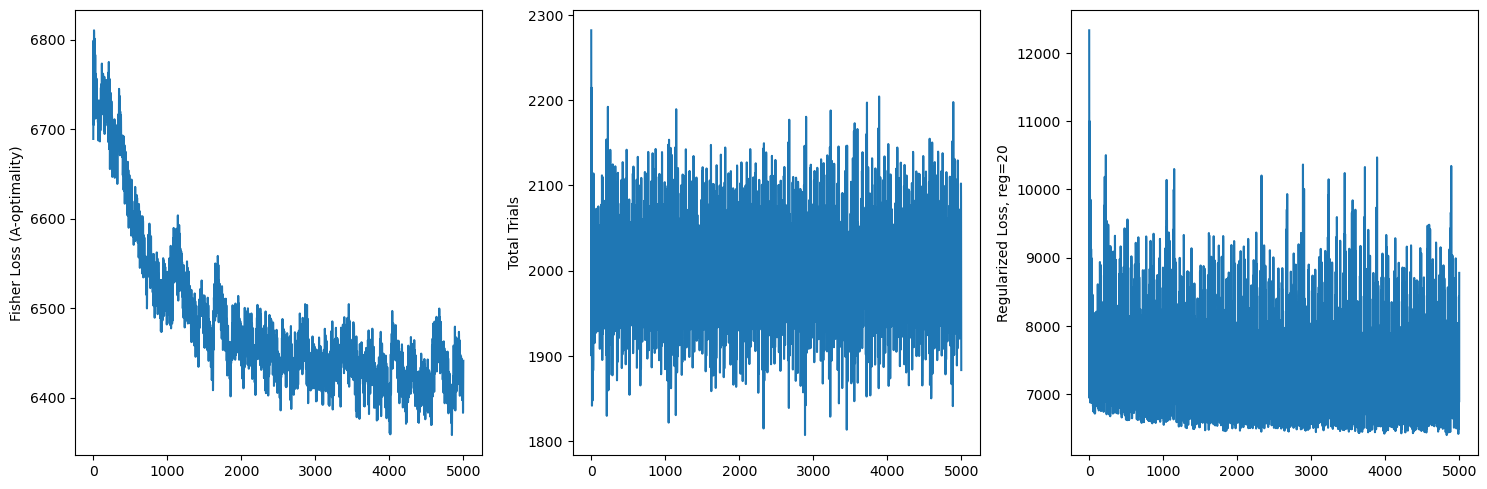

0.012509571073951495 0.015530148528987906


In [17]:
# total_budget = 50000
num_iters = 5

T_prev = np.zeros((amps_scan.shape[0], amps_scan.shape[1]), dtype=float)
budget = 2000   #T_prev.shape[0] * T_prev.shape[1] * 1 #int(total_budget / num_iters)
reg = 20 # 20, 50
T_step_size = 0.05 # 0.05, 0.01
T_n_steps = 5000    # 5000

init_trials = 5
init_amps = 200
ms = [1, 2, 3, 4, 5, 6]
disambiguate = True
verbose = True
R2_cutoff = 0
prob_low = 1 / init_trials

for i in range(len(T_prev)):
    init_inds = np.random.choice(np.arange(len(T_prev[i]), dtype=int), size=init_amps,
                                 replace=False)
    T_prev[i][init_inds] = init_trials

# T_prev[:, np.where(np.count_nonzero(amps_scan[0], axis=1) <= 1)[0]] = init_trials
T_prev_uniform = deepcopy(T_prev)

probs_empirical = sample_spikes_array(probs_true_scan, T_prev, NUM_THREADS=24)
probs_empirical_uniform = deepcopy(probs_empirical)

performances = []
performances_uniform = []
num_samples = []
num_samples_uniform = []

iter_cnt = 0
while True:
    if iter_cnt == 0:
        T_new, w_inits_array, t_final, probs_curr, params_curr = fitting.fisher_sampling_1elec(
                                        probs_empirical, 
                                        T_prev, amps_scan,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff,
                                        min_prob=prob_low)

        performance = get_performance_array(params_true, probs_curr, probs_true_scan)
        performance_uniform = performance

        w_inits_array_uniform = deepcopy(w_inits_array)
        
    else:
        T_new, w_inits_array, t_final, probs_curr, params_curr = fitting.fisher_sampling_1elec(
                                        probs_empirical, 
                                        T_prev, amps_scan,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        # t_final=t_final,
                                        w_inits_array=w_inits_array,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff,
                                        min_prob=prob_low)
        
        performance = get_performance_array(params_true, probs_curr, probs_true_scan)

        input_list_uniform = fitting.generate_input_list(probs_empirical_uniform, amps_scan, 
                                                            T_prev_uniform, w_inits_array_uniform, prob_low,
                                                            disambiguate=disambiguate)

        pool = mp.Pool(processes=24)
        results_uniform = pool.starmap_async(fitting.fit_surface, input_list_uniform)
        mp_output_uniform = results_uniform.get()
        pool.close()

        params_curr_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        w_inits_array_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        probs_curr_uniform = np.zeros(probs_empirical_uniform.shape)

        cnt = 0
        for i in range(len(probs_empirical_uniform)):
            for j in range(len(probs_empirical_uniform[i])):
                params_curr_uniform[i][j] = mp_output_uniform[cnt][0]
                w_inits_array_uniform[i][j] = mp_output_uniform[cnt][1]
                
                probs_curr_uniform[i][j] = fitting.sigmoidND_nonlinear(
                                        sm.add_constant(amps_scan[j], has_constant='add'), 
                                        params_curr_uniform[i][j])

                cnt += 1

        performance_uniform = get_performance_array(params_true, probs_curr_uniform, probs_true_scan)
    
    print(performance, performance_uniform)
    
    performances.append(performance)
    performances_uniform.append(performance_uniform)
    
    num_samples.append(np.sum(T_prev))
    num_samples_uniform.append(np.sum(T_prev_uniform))

    iter_cnt += 1

    if iter_cnt > num_iters:
        break

    p_new = sample_spikes_array(probs_true_scan, T_new, NUM_THREADS=24)
    p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
    T_tmp = T_new + T_prev

    p_tmp = np.nan_to_num(p_tmp, nan=0.5)

    probs_empirical = p_tmp
    T_prev = T_tmp
    
    random_extra = np.random.choice(len(T_new.flatten()), size=int(np.sum(T_new)), replace=True)
    T_new_uniform = np.array(np.bincount(random_extra, minlength=len(T_new.flatten())).astype(int).reshape(T_new.shape), dtype=float)
    # T_new_uniform = np.ones_like(T_prev_uniform, dtype=float)
    p_new_uniform = sample_spikes_array(probs_true_scan, T_new_uniform, NUM_THREADS=24)

    p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])
    T_tmp_uniform = T_prev_uniform + T_new_uniform

    p_tmp_uniform = np.nan_to_num(p_tmp_uniform, nan=0.5)

    probs_empirical_uniform = p_tmp_uniform
    T_prev_uniform = T_tmp_uniform

In [18]:
baseline_trials = 20
T_prev_baseline = np.ones_like(T_prev, dtype=float) * baseline_trials

probs_empirical_baseline = sample_spikes_array(probs_true_scan, T_prev_baseline, NUM_THREADS=24)

w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
for i in range(len(w_inits_array_baseline)):
    for j in range(len(w_inits_array_baseline[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps_scan[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array_baseline[i][j] = w_inits

input_list_baseline = fitting.generate_input_list(probs_empirical_baseline, amps_scan, T_prev_baseline, w_inits_array_baseline,
                                                  1 / baseline_trials,
                                                  disambiguate=disambiguate)

pool = mp.Pool(processes=24)
results_baseline = pool.starmap_async(fitting.fit_surface, input_list_baseline)
mp_output_baseline = results_baseline.get()
pool.close()

params_curr_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
probs_curr_baseline = np.zeros(probs_empirical_baseline.shape)

cnt = 0
for i in range(len(probs_empirical_baseline)):
    for j in range(len(probs_empirical_baseline[i])):
        params_curr_baseline[i][j] = mp_output_baseline[cnt][0]
        w_inits_array_baseline[i][j] = mp_output_baseline[cnt][1]
        
        probs_curr_baseline[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps_scan[j], has_constant='add'), 
                                params_curr_baseline[i][j])

        cnt += 1

performance_baseline = get_performance_array(params_true, probs_curr_baseline, probs_true_scan)

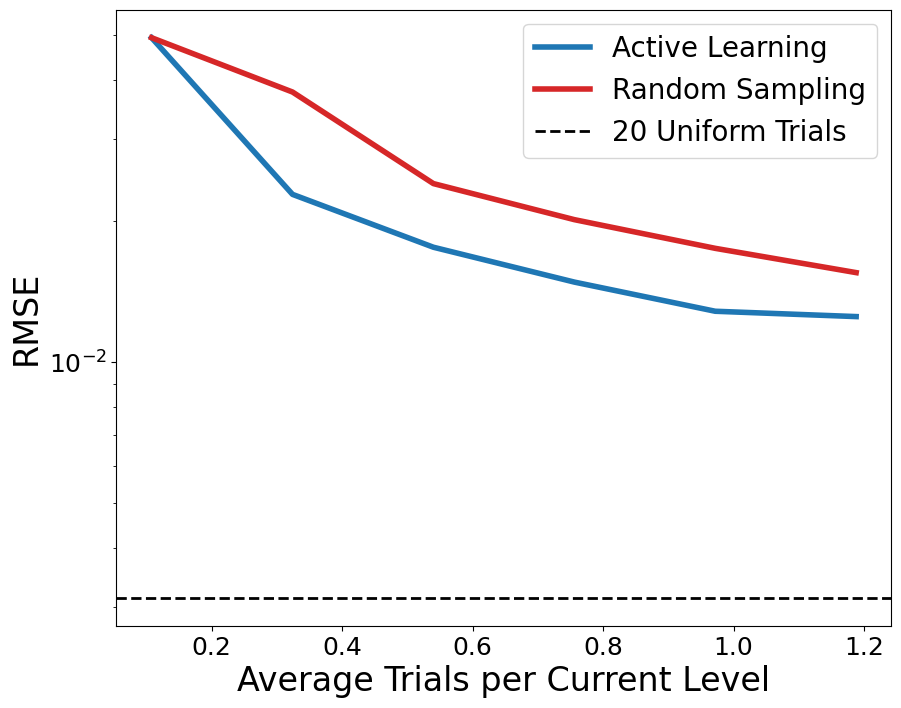

In [19]:
plt.figure(figsize=(10, 8))

plt.semilogy(np.array(num_samples)/T_prev.shape[0]/T_prev.shape[1], performances, linewidth=4, c='tab:blue', label='Active Learning')
plt.semilogy(np.array(num_samples_uniform)/T_prev_uniform.shape[0]/T_prev_uniform.shape[1], performances_uniform, linewidth=4, c='tab:red', label='Random Sampling')

plt.axhline(performance_baseline, c='k', linestyle='--', linewidth=2, label='20 Uniform Trials')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Average Trials per Current Level', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)

# plt.savefig(f'AL_{dataset}_{cell}_{pattern}.png', dpi=300)

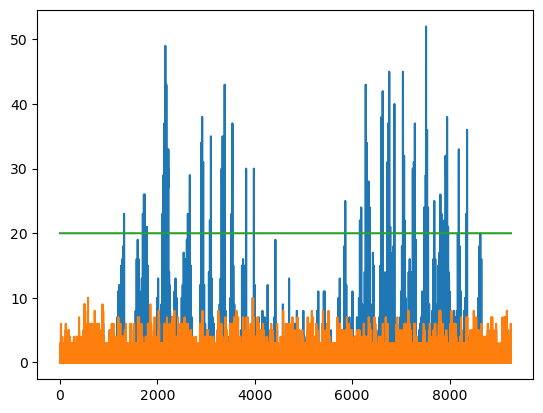

In [20]:
plt.figure()
plt.plot(T_prev.flatten())
plt.plot(T_prev_uniform.flatten())
plt.plot(T_prev_baseline.flatten())

[[ -8.80760213  -1.14840697  -0.73630818  -7.85972803]
 [-12.5097023    0.70701138   0.8393285    8.92589957]
 [ -7.59483509  -4.33075163  -4.54060456  -1.17778131]
 [ -6.30051262   2.98746053   3.27338132   2.64262182]]
1270


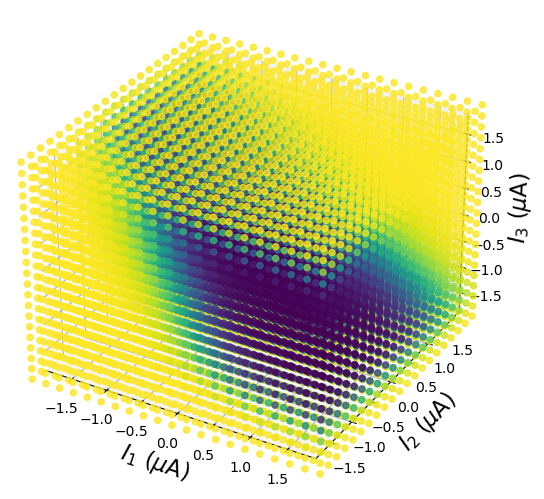

[[-12.08065503   0.48392567   0.63634446   8.57435066]
 [ -9.56998392  -1.28173166  -0.80463028  -8.52868571]
 [ -6.32014472   3.02120463   3.30799465   2.72724438]
 [ -8.36620872  -4.80007087  -5.06121459  -1.2556144 ]]


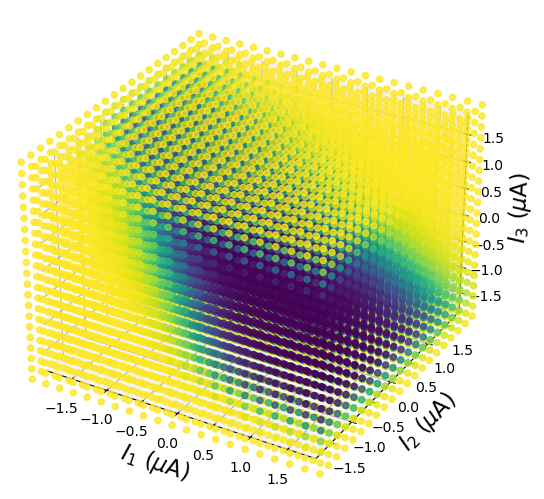

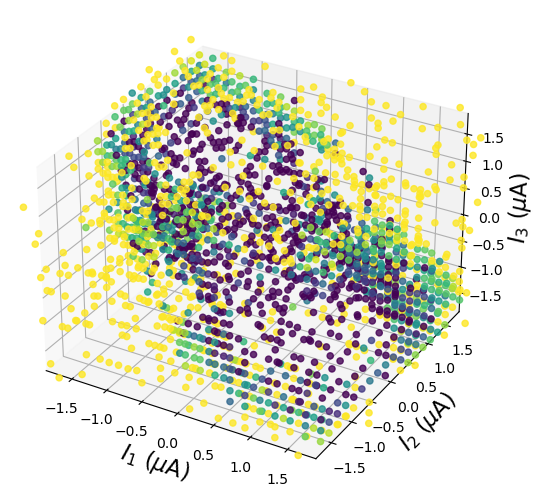

In [21]:
# CHECK DATASET IF NEEDED
from mpl_toolkits.mplot3d import Axes3D

for i in range(len(probs_np)):
    for j in range(len(probs_np[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):
            print(params_true[i][j])
            print(len(np.where(probs_np[i][j][clean_inds_array[i][j]] >= spont_limit)[0]))

            sampled_inds = np.where(T_prev[j] > 0)[0]
            
            fig = plt.figure(0)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps_scan[j][:, 0], 
                              amps_scan[j][:, 1],
                              amps_scan[j][:, 2], marker='o', 
                              c=probs_true_scan[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            print(params_curr[i][j])
            fig = plt.figure(1)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps_scan[j][:, 0], 
                              amps_scan[j][:, 1],
                              amps_scan[j][:, 2], marker='o', 
                              c=probs_curr[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            fig = plt.figure(1)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps_scan[j][sampled_inds, 0], 
                              amps_scan[j][sampled_inds, 1],
                              amps_scan[j][sampled_inds, 2], marker='o', 
                              c=probs_empirical[i][j][sampled_inds], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()